In [ ]:
# set working dictionary
import os
import sys
from google.colab import drive

drive.mount('/content/drive')

os.chdir(os.getcwd())
sys.path.append(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing

## Import Libs

In [ ]:
from datetime import datetime 
from tqdm import tqdm_notebook as tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

## Check Device

In [ ]:
# check device

def check_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'
  
DEVICE = check_device()
print(f"Device: {DEVICE}")

Device: cuda


## Download Data

*Reference of Pytorch MINST*  
[Documnet](https://pytorch.org/vision/stable/datasets.html#mnist) 
[Source](https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST)

In [ ]:
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

#############################################
# construct dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=VAL_BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



## Check Images

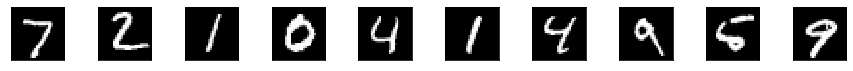

In [ ]:
_, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

# Train model

## Utility Function

In [ ]:
def get_accuracy(model, data_loader, device):
  '''
  Function for computing the accuracy of the predictions over the entire data_loader
  ''' 
  correct_pred = 0 
  n = 0
  
  with torch.no_grad():

    # Set model to eval mode : no drop, 
    model.eval()

    for X, y_true in data_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

  return correct_pred.float() / n

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        # Pytorch accumulate gradient, so we should zero it at first 
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    
    device = check_device()

    train_start = time.time()
 
    # Train model
    for epoch in range(0, epochs):

      # Start timing
      epoch_start = time.time()

      # training
      model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
      train_losses.append(train_loss)

      # validation
      with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)
          
      epoch_end = time.time()
      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch}\t'
            f'Train loss: {train_loss:.4f}\t'
            f'Valid loss: {valid_loss:.4f}\t'
            f'Train accuracy: {100 * train_acc:.2f}\t'
            f'Valid accuracy: {100 * valid_acc:.2f}\t'
            f'Elapse: {(epoch_end - epoch_start):.2f} seconds\t'
            )
      
    # Print Traning Time
    train_end = time.time()
    print("="*50)
    print(f'Total Elapse: {(train_end - train_start):.2f} seconds\t')

    return model, optimizer, train_losses, valid_losses

## Define Model 

In [ ]:
class DNN(nn.Module):

  def __init__(self):
    super(DNN, self).__init__()
    
    self.model = nn.Sequential(            
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )


  def forward(self, x):
    logits = self.model(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

# Print Network Structure
summary(DNN().to(DEVICE), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                   [-1, 84]          33,684
              ReLU-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 37,106
Trainable params: 37,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.14
Estimated Tot

##Train

15:44:20 --- Epoch: 0	Train loss: 0.3463	Valid loss: 0.1118	Train accuracy: 96.69	Valid accuracy: 96.67	Elapse: 12.58 seconds	
15:44:33 --- Epoch: 1	Train loss: 0.0955	Valid loss: 0.0631	Train accuracy: 97.84	Valid accuracy: 98.06	Elapse: 12.86 seconds	
15:44:46 --- Epoch: 2	Train loss: 0.0689	Valid loss: 0.0510	Train accuracy: 98.30	Valid accuracy: 98.40	Elapse: 12.77 seconds	
15:44:59 --- Epoch: 3	Train loss: 0.0541	Valid loss: 0.0495	Train accuracy: 98.50	Valid accuracy: 98.49	Elapse: 12.88 seconds	
15:45:11 --- Epoch: 4	Train loss: 0.0469	Valid loss: 0.0465	Train accuracy: 98.61	Valid accuracy: 98.50	Elapse: 12.81 seconds	
15:45:24 --- Epoch: 5	Train loss: 0.0397	Valid loss: 0.0388	Train accuracy: 99.03	Valid accuracy: 98.72	Elapse: 12.89 seconds	
15:45:37 --- Epoch: 6	Train loss: 0.0356	Valid loss: 0.0348	Train accuracy: 99.22	Valid accuracy: 98.91	Elapse: 12.91 seconds	
15:45:50 --- Epoch: 7	Train loss: 0.0306	Valid loss: 0.0451	Train accuracy: 99.05	Valid accuracy: 98.59	Elapse:

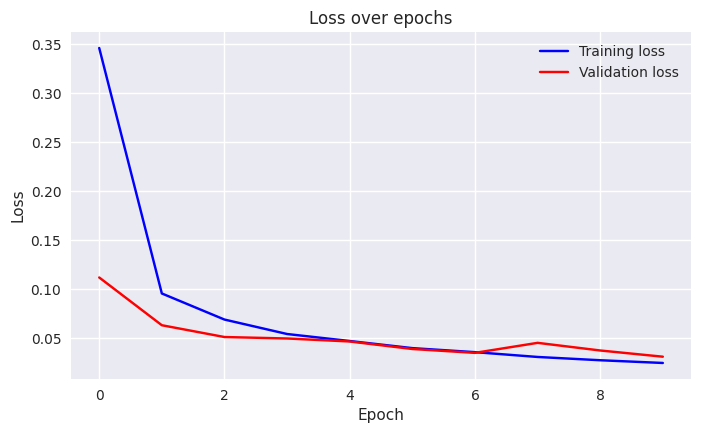

In [ ]:
# Train 
LEARNING_RATE = 0.001
N_EPOCHS = 5

model = DNN().to(DEVICE)

# Define Optmizer and Loss Function
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, train_losses，valid_losses = training_loop(model, criterion, opt, train_loader, test_loader, N_EPOCHS) 

plot_losses(train_losses, valid_losses)